Poleg "standardnih" Python paketov za delovanje potrebujete tudi:

* [PyDaQMx](https://pypi.org/project/PyDAQmx/)
* [pyExSi](https://pypi.org/project/pyExSi/)


---

In [1]:
from DAQTask import DAQTask
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
%matplotlib notebook

# Nastavitev meritve

In [3]:
N_segmentov = 10
input_task = 'PS_random_input'
output_task = 'PS_random_output'

# Nastavitev generiranega signala vzbujanja

Parametre preberemo iz pripravljenega "task"-a:

In [4]:
o_task = DAQTask(output_task)
fs_output = int(o_task.sample_rate)
N_samples_output = int(o_task.samples_per_ch)
o_task.clear_task(wait_until_done=False)

In [5]:
print(fs_output, N_samples_output)

25000 25000


V primeru napake `DuplicateTaskError`pred odpiranjem novega taska zaprite obstoječega z:

In [6]:
o_task.clear_task(wait_until_done=False)

## Priprava naključnega signala za generiranje

Uporabimo paket [pyExSi](https://pypi.org/project/pyExSi/):

In [7]:
import pyExSi as es

Definicija profila vzbujanja - enostranske PSD generiranega signala:

In [8]:
t_out = np.arange(0, N_samples_output) / fs_output
M = N_samples_output//2 + 1 # dolžina enostranske PSD
freq = np.arange(0, M, 1) * fs_output / N_samples_output

freq_lower = 25 # spodnja frekvenčna meja PSD [Hz]
freq_upper = 4000 # zgornja frekvenčna meja PSD [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD

Priprava normalno porazdeljenega naključnega signala:

In [9]:
output_signal = es.random_gaussian(N_samples_output, PSD, fs_output)

<IPython.core.display.Javascript object>


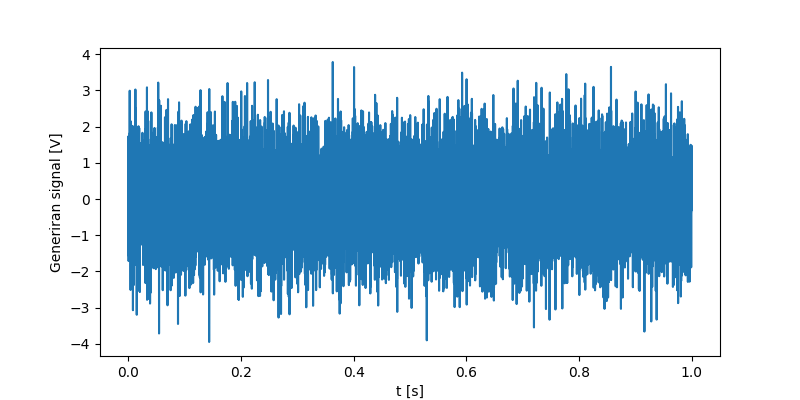

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(t_out, output_signal)
plt.xlabel('t [s]')
plt.ylabel('Generiran signal [V]');

# IO funkcija

In [11]:
def IO_meritev(output_data, N_segmentov=10, input_task_name='PS_random_input', output_task_name='PS_random_output'):
    """
    Funkcija merilne zanke z generiranjem singla `data` in meritivjo dveh kanalov vzbujanja in odziva.
    """
    
    i_task = DAQTask(input_task_name)
    o_task = DAQTask(output_task_name)
    
    # Začetni izris figure grafa 
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)
    ax[0].set_xlabel('t [s]')
    ax[0].set_ylabel('Zajeti signali')
    ax[1].set_xlabel('f [Hz]')
    ax[1].set_ylabel('PSD')

    try:
        o_task.generate(output_data, clear_task=False) # generirranje signala
        time.sleep(0.1)
        i_task.acquire() # zajem signalov

        # Priprava časovnega in frekvenčnega vektorja
        fs = i_task.sample_rate
        dt = 1. / fs
        t = np.arange(i_task.data.shape[1]) * dt
        T = dt * len(t)
        freq = np.fft.rfftfreq(len(t), dt)
        
        # Branje podatkov
        x = i_task.data
        X = np.fft.rfft(x, axis=-1) / x.shape[1]
        PSD = np.abs(np.conj(X) * X  * 2 * T)

        # Začetni izris podatkov
        kanali = i_task.channel_list
        lines = []
        
        lines.append(ax[0].plot(t, x[0], alpha=0.75, label=kanali[0]))
        lines.append(ax[0].plot(t, x[1], alpha=0.75, label=kanali[1]))
        
        lines.append(ax[1].semilogy(freq, PSD[0], alpha=0.75, label=kanali[0]))
        lines.append(ax[1].semilogy(freq, PSD[1], alpha=0.75, label=kanali[1]))
        
        t_legend = ax[0].legend(loc=1)
        ax[0].grid(True)
        f_legend = ax[1].legend(loc=1)
        ax[1].grid(True)

        fig.suptitle(f'Zajetih segmentov: 0 od {N_segmentov}')
        fig.canvas.draw()
        plt.show(block=False)

        # Merilna zanka
        data = []
        for seg in range(N_segmentov):
            # Zajem novega segmenta
            i_task.acquire()
            x = i_task.data
            data.append(x)
            
            X = np.fft.rfft(x, axis=-1) / x.shape[1]
            PSD = np.abs(np.conj(X) * X  * 2 * T)
            RMS = np.sqrt(np.mean(x**2, axis=-1))
        
            # Posodobitev izrisa potadkov
            lines[0][0].set_ydata(x[0])
            lines[1][0].set_ydata(x[1])
            lines[0][0].set_label(f'{kanali[0]}, RMS={RMS[0]:.1f}')
            lines[1][0].set_label(f'{kanali[1]}, RMS={RMS[1]:.1f}')
            
            lines[2][0].set_ydata(PSD[0])
            lines[3][0].set_ydata(PSD[1])

            
            t_legend.remove()
            t_legend = ax[0].legend(loc=1)
            
            # Dinamično prilagajanje merila
            t_plot_ydata = np.asarray([l.get_ydata() for l in ax[0].lines])
            ax[0].set_ylim(-1.1*np.max(np.abs(t_plot_ydata)), 1.1*np.max(np.abs(t_plot_ydata)))
            
            f_plot_ydata = np.asarray([l.get_ydata() for l in ax[1].lines])
            ax[1].set_ylim(np.max([1e-10, np.min(f_plot_ydata)]), 1.1*np.max(np.abs(f_plot_ydata)))
                
            fig.suptitle(f'Zajetih segmentov: {seg+1} od {N_segmentov}')
            fig.canvas.draw()
            
        # Konec meritve
        o_task.clear_task(wait_until_done=False)
        i_task.clear_task(wait_until_done=False)

        # Generiranje praznega signala
        o_task_clear = DAQTask('PS_random_output')
        o_task_clear.generate(1e-10*np.ones_like(output_data), clear_task=False)
        o_task_clear.clear_task(wait_until_done=False)

        # Priprava zajetih podatkov
        podatki = {
            'data': np.array(data),
            'fs': fs,
            'channels': kanali
        }
        return podatki
    
    # Prikaz napake, če se merilna zanka predčasno ustavi
    except Exception as e:
        fig.patch.set_facecolor('r')
        print(f'NAPAKA:\n\t{e}\n')
        i_task.clear_task(wait_until_done=False)
        o_task.clear_task(wait_until_done=False)
        return None

# Meritev

<IPython.core.display.Javascript object>


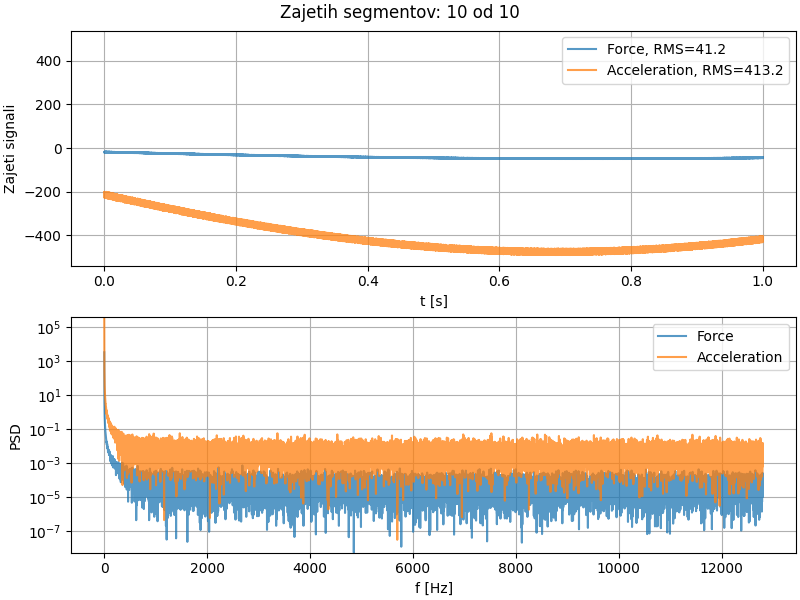

In [12]:
podatki = IO_meritev(output_signal, N_segmentov, input_task, output_task)

## Shranjevanje zajetih segmentov

In [13]:
segmenti = podatki['data']
segmenti.shape # N_segmentov, 2 kanala, točke v segmentu

(10, 2, 25600)

Primer shranjevanja: modul `pickle`:

In [14]:
datoteka = 'meritev.pkl'

In [15]:
with open(datoteka, 'wb') as f:
    pickle.dump(podatki, f)

In [16]:
prebrani_podatki = pickle.load(open(datoteka, 'rb'))
prebrani_podatki.keys()

dict_keys(['data', 'fs', 'channels'])